# CIFAR-10 Dataset: A Computer Vision Benchmark

## Overview
CIFAR-10 is a widely-used benchmark dataset in the field of computer vision and machine learning, specifically designed for object recognition tasks. Originally curated by researchers Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton, it serves as a fundamental resource for developing and evaluating image classification algorithms.

## Dataset Specifications
- **Total Images**: 60,000 color images
- **Image Resolution**: 32x32 pixels
- **Format**: RGB color images
- **Split Distribution**:
  - Training set: 50,000 images (5,000 per class)
  - Testing set: 10,000 images (1,000 per class)

## Object Classes
The dataset contains exactly 10 distinct categories, with each image belonging to precisely one class:
1. Airplane
2. Automobile (excluding pickup trucks)
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck (excluding pickup trucks)

## Dataset Origins
CIFAR-10 represents a carefully curated subset of the larger "80 million tiny images" dataset. Its manageable size and well-balanced class distribution make it particularly suitable for:
- Prototyping new computer vision algorithms
- Educational purposes in machine learning courses
- Benchmarking classification models
- Testing deep learning architectures

## Historical Significance
The dataset has become a standard benchmark in the machine learning community, helping researchers and practitioners evaluate and compare different approaches to image classification since its release.

Will Cukierski. CIFAR-10 - Object Recognition in Images. https://kaggle.com/competitions/cifar-10, 2013. Kaggle.

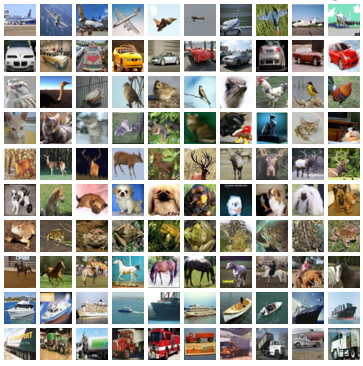


In [1]:
# Download with (x_train, y_train), (x_test, y_test) = cifar10.load_data() #was slow to download
# or 
# https://www.cs.toronto.edu/~kriz/cifar.html #as well was slow
# or 
# https://www.kaggle.com/competitions/cifar-10/data #faster, but filled with junk files in test (against cheating in the competition)

In [2]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow.keras.backend as K
import itertools
from functools import partial

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0].name}")
else:
    print("No GPU found. TensorFlow is running on the CPU.")

Num GPUs Available:  1
TensorFlow is using GPU: /physical_device:GPU:0


In [4]:
object_mapping = {
    "airplane": 0,
    "automobile": 1,
    "bird": 2,
    "cat": 3,
    "deer": 4,
    "dog": 5,
    "frog": 6,
    "horse": 7,
    "ship": 8,
    "truck": 9
}


In [5]:
BATCH_SIZE = 32
IMG_HEIGHT = 32
IMG_WIDTH = 32

In [6]:
image_dir = "datasets/train"
csv_path = "datasets/trainLabels.csv"

In [7]:
labels_df = pd.read_csv(csv_path)
labels_df.sort_values(by="id", inplace=True)
labels_sorted = tf.convert_to_tensor(labels_df[["label"]], dtype=tf.string)

In [8]:
unique_labels = tf.convert_to_tensor(list(object_mapping.keys()), dtype=tf.string)

In [12]:
train_ids, val_ids, train_labels, val_labels = train_test_split(labels_df["id"], labels_df["label"], test_size=0.2, stratify=labels_df["label"], random_state=42)

In [9]:
def load_image(id):
    image_path = os.path.join(image_dir, f"{id}.png")
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        
    label = tf.argmax(tf.equal(unique_labels, labels_sorted[id-1])) ##because index starts from 1 at pictures
    label = tf.cast(label, tf.float16)
    label = tf.reshape(label, [])

    return image, label


In [17]:
train_ids = train_ids.values
val_ids = val_ids.values

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_ids)
train_dataset = train_dataset.map(lambda id: tf.py_function(load_image, [id], [tf.float32, tf.float16]), 
                      num_parallel_calls=tf.data.AUTOTUNE)

In [22]:
val_dataset = tf.data.Dataset.from_tensor_slices(val_ids)
val_dataset = val_dataset.map(lambda id: tf.py_function(load_image, [id], [tf.float32, tf.float16]), 
                      num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
train_dataset = train_dataset.map(lambda x, y: (tf.ensure_shape(x, [32, 32, 3]), tf.ensure_shape(y, [])),
                      num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (tf.ensure_shape(x, [32, 32, 3]), tf.ensure_shape(y, [])),
                      num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
def configure_performance(ds, is_train_ds=True):
    if is_train_ds:
        ds = ds.cache()
        ds = ds.shuffle(1000)
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    else:
        ds = ds.cache()
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [25]:
train_dataset = configure_performance(train_dataset)
val_dataset = configure_performance(val_dataset, is_train_ds=False)

In [26]:
image_batch, labels_batch = next(iter(train_dataset))

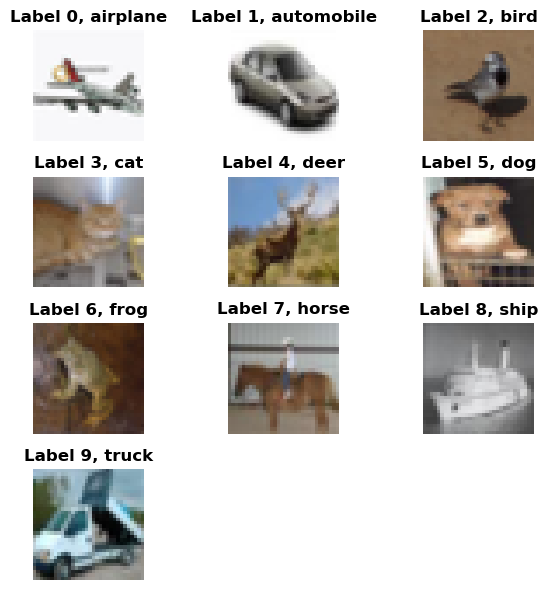

In [27]:
plt.figure(figsize=(6, 6))

for i in range(10):
  ax = plt.subplot(4, 3, i + 1)
  label_idx = tf.argmax(labels_batch.numpy() == i).numpy()
  plt.imshow(image_batch[label_idx])
  plt.title(f"Label {i}, {[objct for objct, value in object_mapping.items() if value ==i][0]}", fontweight="bold")
  plt.axis("off")

plt.tight_layout()


# SLP

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 10)                30730     
                                                                 
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    steps_per_epoch=len(train_dataset) // BATCH_SIZE
)

Epoch 1/10
39/39 [==============================] - 40s 933ms/step - loss: 2.3587 - accuracy: 0.1530 - val_loss: 2.1969 - val_accuracy: 0.2013
Epoch 2/10
39/39 [==============================] - 5s 125ms/step - loss: 2.0997 - accuracy: 0.2556 - val_loss: 2.0797 - val_accuracy: 0.2645
Epoch 3/10
39/39 [==============================] - 5s 142ms/step - loss: 2.1206 - accuracy: 0.2420 - val_loss: 2.0559 - val_accuracy: 0.2499
Epoch 4/10
39/39 [==============================] - 5s 138ms/step - loss: 2.0110 - accuracy: 0.2853 - val_loss: 1.9589 - val_accuracy: 0.3073
Epoch 5/10
39/39 [==============================] - 5s 132ms/step - loss: 2.0869 - accuracy: 0.2684 - val_loss: 2.0763 - val_accuracy: 0.2654
Epoch 6/10
39/39 [==============================] - 5s 122ms/step - loss: 2.0013 - accuracy: 0.2965 - val_loss: 1.8915 - val_accuracy: 0.3420
Epoch 7/10
39/39 [==============================] - 4s 104ms/step - loss: 1.9579 - accuracy: 0.3269 - val_loss: 2.0512 - val_accuracy: 0.3020
Epoch

In [31]:
predictions = model.predict(val_dataset)

313/313 [==============================] - 1s 2ms/step


In [32]:
predicted_labels = tf.argmax(predictions, axis=1)
predicted_labels = tf.cast(predicted_labels, tf.float16)

In [33]:
validation_imgs = []
actual_labels = []
for imgs, labels in val_dataset:
    validation_imgs.extend(imgs.numpy())
    actual_labels.extend(labels.numpy())

validation_imgs = tf.convert_to_tensor(validation_imgs)
actual_labels = tf.convert_to_tensor(actual_labels)

In [34]:
cm = confusion_matrix(actual_labels, predicted_labels)
accuracy = accuracy_score(actual_labels, predicted_labels)

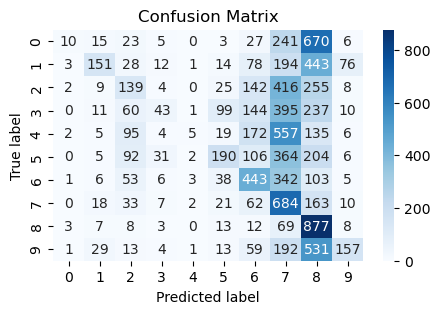

Validation Accuracy: 0.2699


In [35]:
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(f"Validation Accuracy: {accuracy:.4f}")

In [36]:
precision = cm.diagonal() / cm.sum(axis=0)
recall = cm.diagonal() / cm.sum(axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)
output_nodes = 10

for i in range(output_nodes):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1_score[i]:.4f}")

print(f"\nMacro-average F1-score: {np.mean(f1_score):.4f}")

Class 0:
  Precision: 0.4545
  Recall: 0.0100
  F1-score: 0.0196
Class 1:
  Precision: 0.5898
  Recall: 0.1510
  F1-score: 0.2404
Class 2:
  Precision: 0.2555
  Recall: 0.1390
  F1-score: 0.1801
Class 3:
  Precision: 0.3613
  Recall: 0.0430
  F1-score: 0.0769
Class 4:
  Precision: 0.3333
  Recall: 0.0050
  F1-score: 0.0099
Class 5:
  Precision: 0.4368
  Recall: 0.1900
  F1-score: 0.2648
Class 6:
  Precision: 0.3558
  Recall: 0.4430
  F1-score: 0.3947
Class 7:
  Precision: 0.1980
  Recall: 0.6840
  F1-score: 0.3071
Class 8:
  Precision: 0.2424
  Recall: 0.8770
  F1-score: 0.3798
Class 9:
  Precision: 0.5377
  Recall: 0.1570
  F1-score: 0.2430

Macro-average F1-score: 0.2116


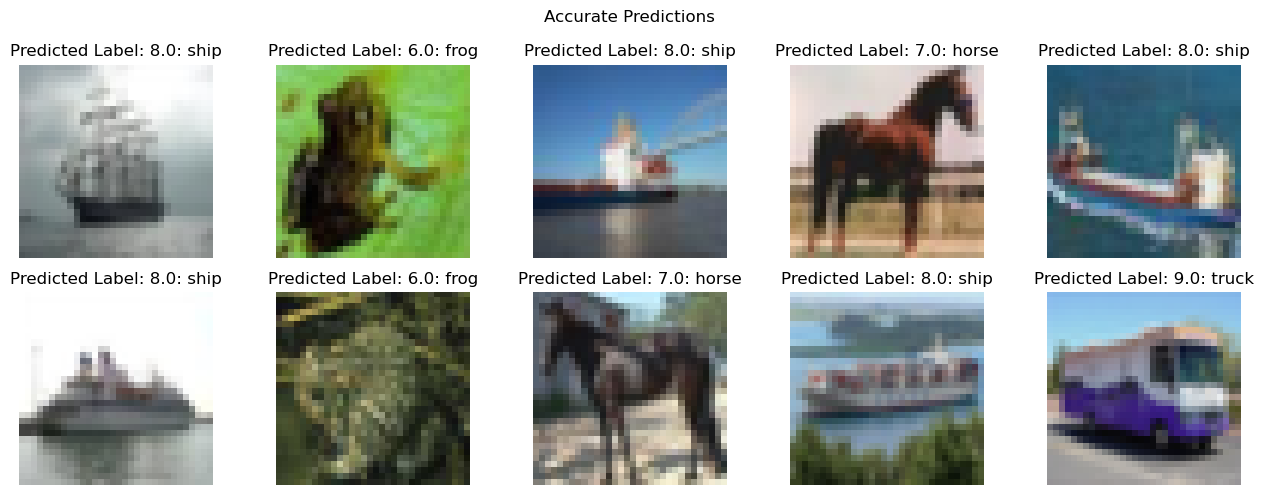

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(13, 5))
plt.suptitle("Accurate Predictions")

for i, ax in enumerate(axes.flat):
    random_index = np.random.choice(np.where(predicted_labels==actual_labels)[0])
    image = validation_imgs[random_index]
    fig = plt.figure
    ax.set_title(f"Predicted Label: {predicted_labels[random_index].numpy()}: {unique_labels[int(predicted_labels[random_index].numpy())].numpy().decode('utf8')}")
    ax.imshow(image)
    ax.set_axis_off()

plt.tight_layout()
plt.show()

# MLP

In [67]:
object_mapping = {
    "airplane": 0,
    "automobile": 1,
    "bird": 2,
    "cat": 3,
    "deer": 4,
    "dog": 5,
    "frog": 6,
    "horse": 7,
    "ship": 8,
    "truck": 9
}


In [68]:
BATCH_SIZE = 32
IMG_HEIGHT = 32
IMG_WIDTH = 32

In [69]:
image_dir = "datasets/train"
csv_path = "datasets/trainLabels.csv"

In [70]:
labels_df = pd.read_csv(csv_path)
labels_df.sort_values(by="id", inplace=True)
labels_sorted = tf.convert_to_tensor(labels_df[["label"]])

In [71]:
unique_labels = tf.convert_to_tensor(list(object_mapping.keys()), dtype=tf.string)

In [72]:
def load_image(id, is_stratified_kfold=False):
    if is_stratified_kfold:
        img_id = id + 1 ## stratified kfold gives back index, thats why 0 index is 1.png
        label_id = id
    else:
        img_id = id
        label_id = id - 1

    image_path = os.path.join(image_dir, f"{img_id}.png")
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        
    label = tf.argmax(tf.equal(unique_labels, labels_sorted[label_id]))
    label = tf.cast(label, tf.float16)
    label = tf.reshape(label, [])

    return image, label


In [73]:
def configure_performance(ds, is_train_ds=True):
    if is_train_ds:
        ds = ds.cache()
        ds = ds.shuffle(1000)
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    else:
        ds = ds.cache()
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [74]:
def build_up_model(hidden_layers_list, lr=float):
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(32, 32, 3)), 
        tf.keras.layers.Flatten(),
    ])

    for attribute in hidden_layers_list:
        if isinstance(attribute, int):
            model.add(tf.keras.layers.Dense(attribute, activation="relu"))
        else:
            model.add(tf.keras.layers.Dropout(attribute))
    
    model.add(tf.keras.layers.Dense(10, activation="softmax"))


    model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=lr),
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
    )

    return model

In [112]:
skf = StratifiedKFold(n_splits=5)

In [113]:
val_accuracies = {}

In [114]:
learning_rates = [0.0001, 0.001, 0.01]
epochs_list = [10, 25, 50]
hidden_layers_list = [(512, 0.2, 256), (128, 0.2, 64), (64, 32)]

param_grid = list(itertools.product(hidden_layers_list, learning_rates,epochs_list))

In [115]:
for params in param_grid:
    current_param_accuracy = []
    for train_ids, val_ids in skf.split(labels_df[["id"]], labels_df[["label"]]):
        
        train_dataset = tf.data.Dataset.from_tensor_slices(train_ids)
        val_dataset = tf.data.Dataset.from_tensor_slices(val_ids)

        train_dataset = train_dataset.map(lambda id: tf.py_function(load_image, [id, True], [tf.float32, tf.float16]), 
                            num_parallel_calls=tf.data.AUTOTUNE)
        val_dataset = val_dataset.map(lambda id: tf.py_function(load_image, [id, True], [tf.float32, tf.float16]), 
                            num_parallel_calls=tf.data.AUTOTUNE)
        
        train_dataset = train_dataset.map(lambda x, y: (tf.ensure_shape(x, [32, 32, 3]), tf.ensure_shape(y, [])),
                            num_parallel_calls=tf.data.AUTOTUNE)
        val_dataset = val_dataset.map(lambda x, y: (tf.ensure_shape(x, [32, 32, 3]), tf.ensure_shape(y, [])),
                            num_parallel_calls=tf.data.AUTOTUNE)
        
        train_dataset = configure_performance(train_dataset)
        val_dataset = configure_performance(val_dataset, is_train_ds=False)

        hidden_layers, lr, epochs = params

        model = build_up_model(hidden_layers, lr)

        model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        steps_per_epoch=len(train_dataset) // BATCH_SIZE
        )

        predictions = model.predict(val_dataset)
        predicted_labels = tf.argmax(predictions, axis=1)
        predicted_labels = tf.cast(predicted_labels, tf.float16)

        actual_labels = []
        for _, labels in val_dataset:
            actual_labels.extend(labels.numpy())

        actual_labels = tf.convert_to_tensor(actual_labels)

        current_param_accuracy.append(accuracy_score(actual_labels, predicted_labels))

        del model
        K.clear_session()
    

    val_accuracies[params] =  sum(current_param_accuracy) / len(current_param_accuracy)

Epoch 1/10
39/39 [==============================] - 38s 895ms/step - loss: 2.2533 - accuracy: 0.1587 - val_loss: 2.1256 - val_accuracy: 0.2456
Epoch 2/10
39/39 [==============================] - 6s 155ms/step - loss: 2.1701 - accuracy: 0.1939 - val_loss: 2.1133 - val_accuracy: 0.1982
Epoch 3/10
39/39 [==============================] - 5s 124ms/step - loss: 2.0860 - accuracy: 0.2244 - val_loss: 2.0502 - val_accuracy: 0.2375
Epoch 4/10
39/39 [==============================] - 5s 123ms/step - loss: 2.0735 - accuracy: 0.2364 - val_loss: 1.9807 - val_accuracy: 0.2924
Epoch 5/10
39/39 [==============================] - 4s 118ms/step - loss: 2.0648 - accuracy: 0.2364 - val_loss: 1.9903 - val_accuracy: 0.2803
Epoch 6/10
39/39 [==============================] - 5s 119ms/step - loss: 2.0415 - accuracy: 0.2652 - val_loss: 1.9407 - val_accuracy: 0.3032
Epoch 7/10
39/39 [==============================] - 4s 109ms/step - loss: 2.0187 - accuracy: 0.2644 - val_loss: 1.9394 - val_accuracy: 0.2972
Epoch

In [116]:
val_accuracies

{((512, 0.2, 256), 0.0001, 10): 0.31762,
 ((512, 0.2, 256), 0.0001, 25): 0.3576,
 ((512, 0.2, 256), 0.0001, 50): 0.36738,
 ((512, 0.2, 256), 0.001, 10): 0.28962,
 ((512, 0.2, 256), 0.001, 25): 0.32702,
 ((512, 0.2, 256), 0.001, 50): 0.3352,
 ((512, 0.2, 256), 0.01, 10): 0.16766,
 ((512, 0.2, 256), 0.01, 25): 0.15428000000000003,
 ((512, 0.2, 256), 0.01, 50): 0.17584,
 ((128, 0.2, 64), 0.0001, 10): 0.28937999999999997,
 ((128, 0.2, 64), 0.0001, 25): 0.33674,
 ((128, 0.2, 64), 0.0001, 50): 0.33998,
 ((128, 0.2, 64), 0.001, 10): 0.2791,
 ((128, 0.2, 64), 0.001, 25): 0.30635999999999997,
 ((128, 0.2, 64), 0.001, 50): 0.28991999999999996,
 ((128, 0.2, 64), 0.01, 10): 0.17376,
 ((128, 0.2, 64), 0.01, 25): 0.1629,
 ((128, 0.2, 64), 0.01, 50): 0.17744,
 ((64, 32), 0.0001, 10): 0.26894,
 ((64, 32), 0.0001, 25): 0.32204,
 ((64, 32), 0.0001, 50): 0.33336,
 ((64, 32), 0.001, 10): 0.2863,
 ((64, 32), 0.001, 25): 0.31986000000000003,
 ((64, 32), 0.001, 50): 0.34456,
 ((64, 32), 0.01, 10): 0.1708,
 (

In [117]:
sorted(val_accuracies.items(), key=lambda x:x[1], reverse=True)


[(((512, 0.2, 256), 0.0001, 50), 0.36738),
 (((512, 0.2, 256), 0.0001, 25), 0.3576),
 (((64, 32), 0.001, 50), 0.34456),
 (((128, 0.2, 64), 0.0001, 50), 0.33998),
 (((128, 0.2, 64), 0.0001, 25), 0.33674),
 (((512, 0.2, 256), 0.001, 50), 0.3352),
 (((64, 32), 0.0001, 50), 0.33336),
 (((512, 0.2, 256), 0.001, 25), 0.32702),
 (((64, 32), 0.0001, 25), 0.32204),
 (((64, 32), 0.001, 25), 0.31986000000000003),
 (((512, 0.2, 256), 0.0001, 10), 0.31762),
 (((128, 0.2, 64), 0.001, 25), 0.30635999999999997),
 (((128, 0.2, 64), 0.001, 50), 0.28991999999999996),
 (((512, 0.2, 256), 0.001, 10), 0.28962),
 (((128, 0.2, 64), 0.0001, 10), 0.28937999999999997),
 (((64, 32), 0.001, 10), 0.2863),
 (((128, 0.2, 64), 0.001, 10), 0.2791),
 (((64, 32), 0.0001, 10), 0.26894),
 (((128, 0.2, 64), 0.01, 50), 0.17744),
 (((512, 0.2, 256), 0.01, 50), 0.17584),
 (((128, 0.2, 64), 0.01, 10), 0.17376),
 (((64, 32), 0.01, 10), 0.1708),
 (((512, 0.2, 256), 0.01, 10), 0.16766),
 (((64, 32), 0.01, 50), 0.16496),
 (((128, 0

In [75]:
best_params = ((512, 0.2, 256), 0.0001, 50)

## Best Params Test

In [76]:
train_ids, val_ids, train_labels, val_labels = train_test_split(labels_df["id"], labels_df["label"], test_size=0.2, stratify=labels_df["label"], random_state=42)

In [77]:
train_ids = train_ids.values
val_ids = val_ids.values

In [78]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_ids)
train_dataset = train_dataset.map(lambda id: tf.py_function(load_image, [id, False], [tf.float32, tf.float16]), 
                      num_parallel_calls=tf.data.AUTOTUNE)

In [79]:
val_dataset = tf.data.Dataset.from_tensor_slices(val_ids)
val_dataset = val_dataset.map(lambda id: tf.py_function(load_image, [id, False], [tf.float32, tf.float16]), 
                      num_parallel_calls=tf.data.AUTOTUNE)

In [80]:
train_dataset = train_dataset.map(lambda x, y: (tf.ensure_shape(x, [32, 32, 3]), tf.ensure_shape(y, [])),
                      num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (tf.ensure_shape(x, [32, 32, 3]), tf.ensure_shape(y, [])),
                      num_parallel_calls=tf.data.AUTOTUNE)

In [81]:
train_dataset = configure_performance(train_dataset)
val_dataset = configure_performance(val_dataset, is_train_ds=False)

In [83]:
hidden_layers, lr, epochs = best_params

model = build_up_model(hidden_layers, lr)

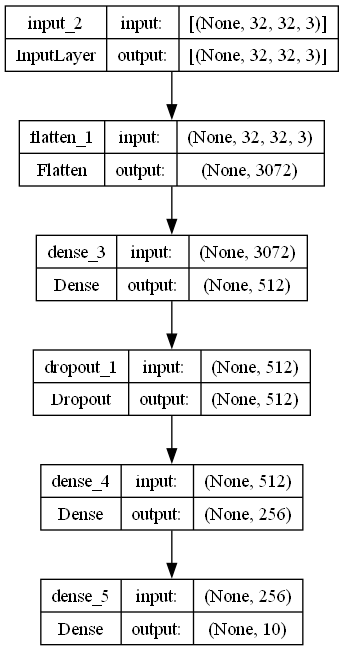

In [84]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [85]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    steps_per_epoch=len(train_dataset) // BATCH_SIZE
)

Epoch 1/50
39/39 [==============================] - 37s 863ms/step - loss: 2.3043 - accuracy: 0.1370 - val_loss: 2.1998 - val_accuracy: 0.1877
Epoch 2/50
39/39 [==============================] - 6s 146ms/step - loss: 2.1603 - accuracy: 0.1979 - val_loss: 2.0677 - val_accuracy: 0.2625
Epoch 3/50
39/39 [==============================] - 5s 138ms/step - loss: 2.1183 - accuracy: 0.2131 - val_loss: 2.0480 - val_accuracy: 0.2527
Epoch 4/50
39/39 [==============================] - 5s 143ms/step - loss: 2.0377 - accuracy: 0.2644 - val_loss: 2.0116 - val_accuracy: 0.2838
Epoch 5/50
39/39 [==============================] - 4s 107ms/step - loss: 2.0439 - accuracy: 0.2460 - val_loss: 1.9706 - val_accuracy: 0.2920
Epoch 6/50
39/39 [==============================] - 4s 118ms/step - loss: 2.0245 - accuracy: 0.2636 - val_loss: 1.9552 - val_accuracy: 0.3078
Epoch 7/50
39/39 [==============================] - 4s 115ms/step - loss: 1.9705 - accuracy: 0.2796 - val_loss: 1.9358 - val_accuracy: 0.3051
Epoch

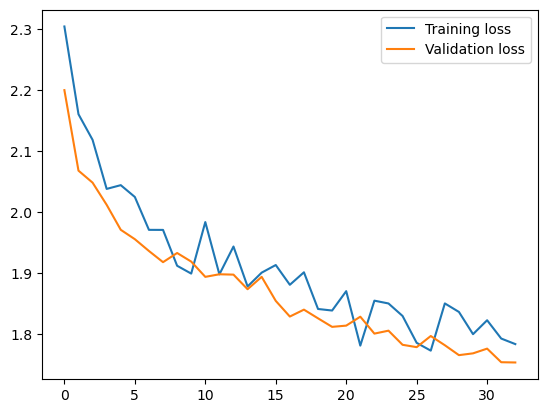

In [86]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [101]:
predictions = model.predict(val_dataset)

  1/313 [..............................] - ETA: 5s

313/313 [==============================] - 1s 2ms/step


In [102]:
prediction_confidence = tf.reduce_max(predictions, axis=1)
predicted_labels = tf.argmax(predictions, axis=1)
predicted_labels = tf.cast(predicted_labels, tf.float16)

In [104]:
validation_imgs = []
actual_labels = []
for imgs, labels in val_dataset:
    validation_imgs.extend(imgs.numpy())
    actual_labels.extend(labels.numpy())

validation_imgs = tf.convert_to_tensor(validation_imgs)
actual_labels = tf.convert_to_tensor(actual_labels)

In [105]:
cm = confusion_matrix(actual_labels, predicted_labels)
accuracy = accuracy_score(actual_labels, predicted_labels)

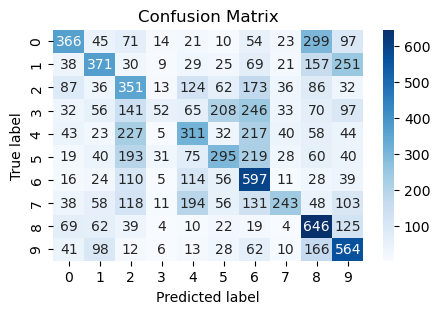

Validation Accuracy: 0.3796


In [106]:
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(f"Validation Accuracy: {accuracy:.4f}")

In [107]:
precision = cm.diagonal() / cm.sum(axis=0)
recall = cm.diagonal() / cm.sum(axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)
output_nodes = 10

for i in range(output_nodes):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1_score[i]:.4f}")

print(f"\nMacro-average F1-score: {np.mean(f1_score):.4f}")

Class 0:
  Precision: 0.4887
  Recall: 0.3660
  F1-score: 0.4185
Class 1:
  Precision: 0.4563
  Recall: 0.3710
  F1-score: 0.4093
Class 2:
  Precision: 0.2717
  Recall: 0.3510
  F1-score: 0.3063
Class 3:
  Precision: 0.3467
  Recall: 0.0520
  F1-score: 0.0904
Class 4:
  Precision: 0.3253
  Recall: 0.3110
  F1-score: 0.3180
Class 5:
  Precision: 0.3715
  Recall: 0.2950
  F1-score: 0.3289
Class 6:
  Precision: 0.3341
  Recall: 0.5970
  F1-score: 0.4284
Class 7:
  Precision: 0.5412
  Recall: 0.2430
  F1-score: 0.3354
Class 8:
  Precision: 0.3993
  Recall: 0.6460
  F1-score: 0.4935
Class 9:
  Precision: 0.4052
  Recall: 0.5640
  F1-score: 0.4716

Macro-average F1-score: 0.3600


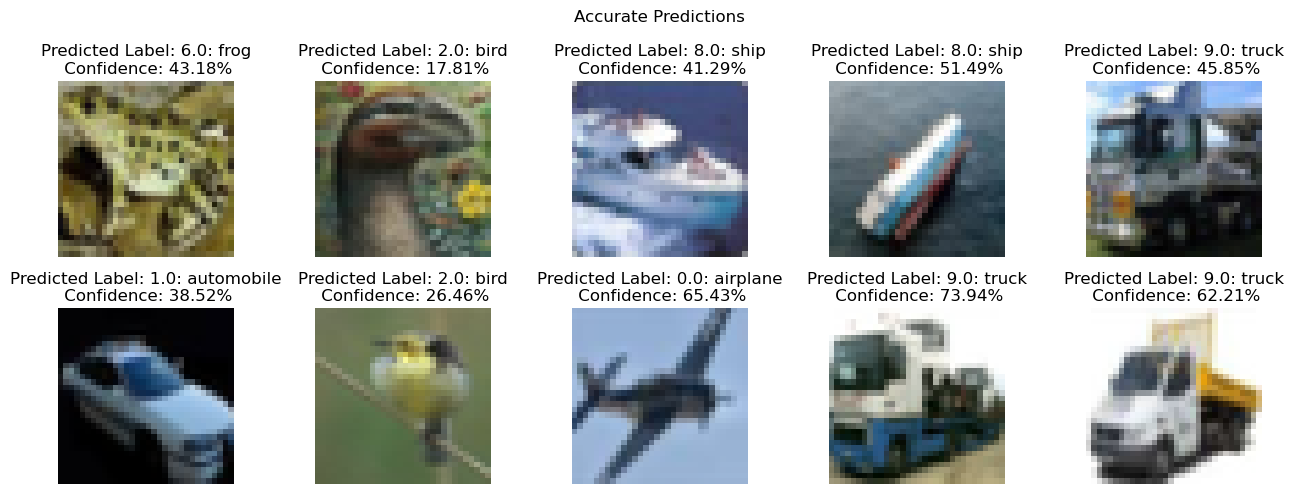

In [111]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(13, 5))
plt.suptitle("Accurate Predictions")

for i, ax in enumerate(axes.flat):
    random_index = np.random.choice(np.where(predicted_labels==actual_labels)[0])
    image = validation_imgs[random_index]
    fig = plt.figure
    ax.set_title(f"Predicted Label: {predicted_labels[random_index].numpy()}: {unique_labels[int(predicted_labels[random_index].numpy())].numpy().decode('utf8')}\n Confidence: {round(prediction_confidence[random_index].numpy()*100, 2)}%")
    ax.imshow(image)
    ax.set_axis_off()

plt.tight_layout()
plt.show()

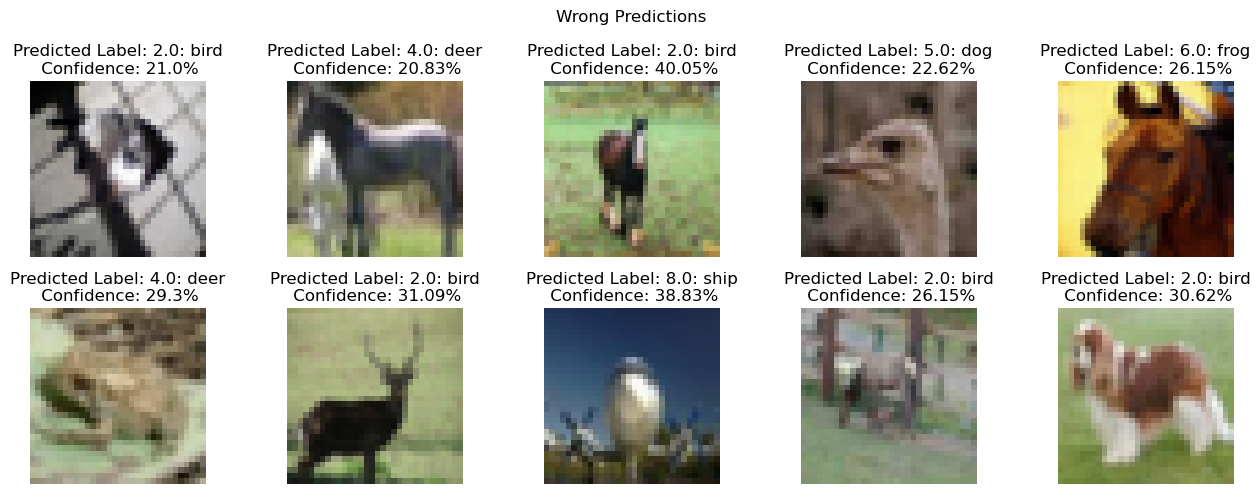

In [112]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(13, 5))
plt.suptitle("Wrong Predictions")

for i, ax in enumerate(axes.flat):
    random_index = np.random.choice(np.where(predicted_labels!=actual_labels)[0])
    image = validation_imgs[random_index]
    fig = plt.figure
    ax.set_title(f"Predicted Label: {predicted_labels[random_index].numpy()}: {unique_labels[int(predicted_labels[random_index].numpy())].numpy().decode('utf8')}\n Confidence: {round(prediction_confidence[random_index].numpy()*100, 2)}%")
    ax.imshow(image)
    ax.set_axis_off()

plt.tight_layout()
plt.show()

# Save model

In [ ]:
del model
K.clear_session()

In [115]:
ids = np.arange(1, 50001)

In [116]:
train_dataset = tf.data.Dataset.from_tensor_slices(ids)
train_dataset = train_dataset.map(lambda id: tf.py_function(load_image, [id, False], [tf.float32, tf.float16]), 
                      num_parallel_calls=tf.data.AUTOTUNE)

In [117]:
train_dataset = train_dataset.map(lambda x, y: (tf.ensure_shape(x, [32, 32, 3]), tf.ensure_shape(y, [])),
                      num_parallel_calls=tf.data.AUTOTUNE)

In [118]:
train_dataset = configure_performance(train_dataset)

In [121]:
hidden_layers, lr, epochs = best_params

model = build_up_model(hidden_layers, lr)

In [122]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=len(train_dataset) // BATCH_SIZE
)

Epoch 1/50


48/48 [==============================] - 9s 116ms/step - loss: 2.2431 - accuracy: 0.1719
Epoch 2/50
48/48 [==============================] - 6s 116ms/step - loss: 2.1057 - accuracy: 0.2279
Epoch 3/50
48/48 [==============================] - 6s 120ms/step - loss: 2.0479 - accuracy: 0.2617
Epoch 4/50
48/48 [==============================] - 6s 125ms/step - loss: 2.0447 - accuracy: 0.2409
Epoch 5/50
48/48 [==============================] - 7s 155ms/step - loss: 1.9896 - accuracy: 0.2832
Epoch 6/50
48/48 [==============================] - 7s 151ms/step - loss: 1.9784 - accuracy: 0.2982
Epoch 7/50
48/48 [==============================] - 6s 130ms/step - loss: 2.0047 - accuracy: 0.2839
Epoch 8/50
48/48 [==============================] - 5s 114ms/step - loss: 1.9517 - accuracy: 0.2962
Epoch 9/50
48/48 [==============================] - 6s 126ms/step - loss: 1.9313 - accuracy: 0.3086
Epoch 10/50
48/48 [==============================] - 5s 110ms/step - loss: 1.9189 - accuracy: 0.3223
Epoch 11/5

In [123]:
model.save("mlp_model")

INFO:tensorflow:Assets written to: mlp_model\assets
